# Network-based Gene Prioritization from GWAS Data
MED283: Network Biology & Biomedicine  
Nadia Arang & Kevin Chau

In [99]:
%matplotlib inline

import ndex2
import networkx as nx
from networkx.algorithms import community
import pandas as pd
import numpy as np

## Initial data loading

In [2]:
# Load pcnet from server
pc_nice = ndex2.create_nice_cx_from_server(server = "http://public.ndexbio.org", 
                                           uuid = "f93f402c-86d4-11e7-a10d-0ac135e8bacf")

In [3]:
# Cast as networkx object
# First cast to pandas since networkx 2.1 is incompatible with ndex2
pc_pd = pc_nice.to_pandas_dataframe()
pcnet = nx.from_pandas_edgelist(pc_pd)

In [19]:
# Load significance values for snps
snps = {_[0]: _[8] 
        for _ in [line.strip().split() 
                  for line in open("../src/snp_level_summary_stats_pmid_25056061.txt", "r").readlines()[1:]]}

In [43]:
# Rudimentary gene scoring by # snps normalized by gene length
genes_score = {_[1]: {"Score": [(int(_[5]) / (int(_[4]) - int(_[3])))]}
               for _ in [line.strip().split() 
                         for line in open("../src/gene_level_summary_stats_pmid_25056061.txt", "r").readlines()[1:]]}

In [59]:
# Gene level p-value
genes_p = {_[1]: {"Pvalue": float(_[8])} 
          for _ in [line.strip().split() 
                    for line in open("../src/gene_level_summary_stats_pmid_25056061.txt", "r").readlines()[1:]]}

In [60]:
genes_p

{'HIST1H4K': {'Pvalue': 5.07118e-10},
 'HIST1H2AK': {'Pvalue': 5.07118e-10},
 'HIST1H2BN': {'Pvalue': 5.07118e-10},
 'HIST1H2AL': {'Pvalue': 7.05379e-10},
 'HIST1H1B': {'Pvalue': 7.05379e-10},
 'HIST1H3I': {'Pvalue': 7.05379e-10},
 'HIST1H4L': {'Pvalue': 7.05379e-10},
 'PGBD1': {'Pvalue': 1.23604e-09},
 'HIST1H1E': {'Pvalue': 1.4581e-09},
 'HIST1H2BD': {'Pvalue': 1.4581e-09},
 'ZKSCAN4': {'Pvalue': 1.79494e-09},
 'ZSCAN12': {'Pvalue': 1.98264e-09},
 'ZNF165': {'Pvalue': 4.12863e-09},
 'NKAPL': {'Pvalue': 5.03498e-09},
 'OR2B2': {'Pvalue': 1.02055e-08},
 'NT5C2': {'Pvalue': 2.2317e-08},
 'ZSCAN23': {'Pvalue': 2.70701e-08},
 'EI24': {'Pvalue': 2.91065e-08},
 'ZNF184': {'Pvalue': 4.02935e-08},
 'ZKSCAN3': {'Pvalue': 4.75173e-08},
 'MAD1L1': {'Pvalue': 5.06103e-08},
 'CNNM2': {'Pvalue': 6.39413e-08},
 'AS3MT': {'Pvalue': 1.30103e-07},
 'STT3A': {'Pvalue': 1.50685e-07},
 'CHEK1': {'Pvalue': 1.79376e-07},
 'HIST1H2BL': {'Pvalue': 2.41439e-07},
 'HIST1H3H': {'Pvalue': 2.41439e-07},
 'HIST1H2A

In [116]:
# Classifications
gene_class = [1 if g in genes_p and genes_p[g]["Pvalue"] <= 0.00000005 else 0 for g in pcnet.nodes]

In [123]:
pclap = nx.laplacian_matrix(pcnet)

## Adding information to the network

In [61]:
nx.set_node_attributes(pcnet, values = genes_p)

## Community detection

Detect communities within PCNet and perform predictions on those communities

## Support Vector Machine classification

We can try stratifying genes based on a binary feature vector of gene-gene associations from PCNet with the predicted value as GWAS significance.

In [12]:
from sklearn import svm
help(svm)

Help on package sklearn.svm in sklearn:

NAME
    sklearn.svm - The :mod:`sklearn.svm` module includes Support Vector Machine algorithms.

PACKAGE CONTENTS
    base
    bounds
    classes
    liblinear
    libsvm
    libsvm_sparse
    setup
    tests (package)

CLASSES
    sklearn.base.BaseEstimator(builtins.object)
        sklearn.svm.classes.LinearSVC(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
    sklearn.base.RegressorMixin(builtins.object)
        sklearn.svm.classes.LinearSVR(sklearn.linear_model.base.LinearModel, sklearn.base.RegressorMixin)
        sklearn.svm.classes.NuSVR(sklearn.svm.base.BaseLibSVM, sklearn.base.RegressorMixin)
        sklearn.svm.classes.SVR(sklearn.svm.base.BaseLibSVM, sklearn.base.RegressorMixin)
    sklearn.linear_model.base.LinearClassifierMixin(sklearn.base.ClassifierMixin)
        sklearn.svm.classes.LinearSVC(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassif

In [13]:
# Create feature vector for each gene (node) from PCNet
all_genes = pcnet.nodes

In [15]:
X = []
for gene in all_genes:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-15-5fbd0ff50e77>, line 2)

## Spectral clustering

In [101]:
pc_adj = pd.DataFrame(nx.adjacency_matrix(pcnet).toarray())
pc_adj_mat = pc_adj

In [102]:
pc_adj.columns = pcnet.nodes
pc_adj.index = pcnet.nodes

In [96]:
pc_adj.head()

,UBE2Q1,RNF14,UBE2Q2,TMCO1,UBAC1,WWP1,ZNF706,MIB2,RNF114,RNF115,...,TMEM26,RAD51AP2,AC010422.6,PLEKHA8P1,CD300LD,BAGE4,FAM181B,IGFL3,BAT4,TPT1P8
UBE2Q1,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
RNF14,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UBE2Q2,1,1,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
TMCO1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UBAC1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
from sklearn.cluster import SpectralClustering

In [127]:
sc = SpectralClustering(eigen_solver = "amg")

In [128]:
sc.fit_predict(pc_adj_mat)

/usr/local/lib/python3.6/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/usr/local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

## Naive Bayes

In [109]:
from sklearn.naive_bayes import GaussianNB

In [110]:
model = GaussianNB()

In [118]:
model.fit(pc_adj_mat, y = gene_class)

GaussianNB(priors=None)

In [122]:
model.predict(np.array([1,0,1,0,1,0,1,1,1,0]).reshape(-1, 1))

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1])

## PCA


In [129]:
from sklearn.decomposition import PCA

In [130]:
pca = PCA(n_components = 2)

In [143]:
pca.fit(pd.DataFrame(pclap.toarray()))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [144]:
pca.explained_variance_

array([5099.19036741,  659.95082241])

In [138]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [148]:
proj = pca.fit_transform(pd.DataFrame(pclap.toarray()))

In [149]:
proj.shape

(19781, 2)

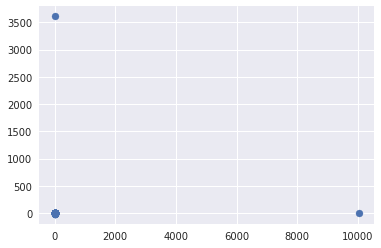

In [150]:
plt.scatter(proj[:, 0], proj[:, 1])

In [151]:
pclap_df = pd.DataFrame(pclap.toarray())

In [152]:
pclap_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19771,19772,19773,19774,19775,19776,19777,19778,19779,19780
0,364,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
1,-1,603,-1,-1,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1,-1,400,0,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
3,-1,-1,0,634,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1,0,-1,0,415,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
[_ for _ in proj if _[0] > 3000]

[array([1.00424999e+04, 9.83019865e-02])]